In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_excel("2026-01-22_MC38-12_d1_collagen_domes_ivan.xlsx")
df2 = pd.read_excel("2026-01-23_MC38-12_d2_collagen_dome_ivan.xlsx")

df = pd.concat([df1, df2], ignore_index=True)

In [4]:
excel_file1 = pd.ExcelFile("2026-01-22_MC38-12_d1_collagen_domes_ivan.xlsx")
excel_file2 = pd.ExcelFile("2026-01-23_MC38-12_d2_collagen_dome_ivan.xlsx")

print("Day 1 excel file:", excel_file1.sheet_names)
print("Day 2 excel file:", excel_file2.sheet_names)

Day 1 excel file: ['Plate1', 'Plate 2', 'Sheet1']
Day 2 excel file: ['plate2', 'plate1', 'Sheet1']


In [5]:
def find_table_in_sheet(sheet_df, anchors="<>"):
    mask = sheet_df.astype(str).applymap(lambda x: x.strip() == anchors)
    if not mask.any().any():
        return None

    anchor_row, anchor_col = np.argwhere(mask.values)[0]

    def is_empty(x):
        return pd.isna(x) or (isinstance(x, str) and x.strip() == "")

    end_col = anchor_col + 1
    while end_col < sheet_df.shape[1] and not sheet_df.iloc[anchor_row + 1 :, end_col].apply(is_empty).all():
        end_col += 1

    end_row = anchor_row + 1
    while end_row < sheet_df.shape[0] and not sheet_df.iloc[end_row, anchor_col + 1 : end_col].apply(is_empty).all():
        end_row += 1

    extract_header = sheet_df.iloc[anchor_row, anchor_col + 1 : end_col]
    extract_index = sheet_df.iloc[anchor_row + 1 : end_row, anchor_col]

    def clean_header(x):
        x = str(x).strip()
        try:
            x = float(x)
            return int(x) if x.is_integer() else x
        except ValueError:
            return x

    cols = [clean_header(x) for x in extract_header]

    index = extract_index.where(~extract_index.isna(), "").astype(str).str.strip().tolist()

    table = sheet_df.iloc[anchor_row + 1 : end_row, anchor_col + 1 : end_col].copy()
    table.columns = cols
    table.index = index

    return table

In [6]:
def find_all_tables_in_sheet(sheet_df, anchor="<>"):

    mask = sheet_df.astype(str).applymap(lambda x: x.strip() == anchor)
    positions = np.argwhere(mask.values)

    if len(positions) == 0:
        return []

    def is_empty(x):
        return pd.isna(x) or (isinstance(x, str) and x.strip() == "")

    def clean_header(x):
        x = str(x).strip()
        try:
            x = float(x)
            return int(x) if x.is_integer() else x
        except ValueError:
            return x

    tables = []

    for anchor_row, anchor_col in positions:

        end_col = anchor_col + 1
        while end_col < sheet_df.shape[1] and not sheet_df.iloc[anchor_row + 1:, end_col].apply(is_empty).all():
            end_col += 1

        end_row = anchor_row + 1
        while end_row < sheet_df.shape[0] and not sheet_df.iloc[end_row, anchor_col + 1:end_col].apply(is_empty).all():
            end_row += 1

        extract_header = sheet_df.iloc[anchor_row, anchor_col + 1:end_col]
        extract_index  = sheet_df.iloc[anchor_row + 1:end_row, anchor_col]

        cols = [clean_header(x) for x in extract_header]
        index = extract_index.fillna("").astype(str).str.strip().tolist()

        table = sheet_df.iloc[anchor_row + 1:end_row, anchor_col + 1:end_col].copy()
        table.columns = cols
        table.index = index

        tables.append(table)

    return tables


In [7]:
sheets = pd.read_excel(
    "2026-01-22_MC38-12_d1_collagen_domes_ivan.xlsx",
    sheet_name=["Plate1", "Plate 2"],
    header=None
)

tables = {}

for name in ["Plate1", "Plate 2"]:
    tables[name] = find_all_tables_in_sheet(sheets[name], anchor="<>")
tables

/var/folders/34/n0768sv507xdn1r6jt0yv6600000gn/T/ipykernel_36021/191618559.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = sheet_df.astype(str).applymap(lambda x: x.strip() == anchor)
/var/folders/34/n0768sv507xdn1r6jt0yv6600000gn/T/ipykernel_36021/191618559.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = sheet_df.astype(str).applymap(lambda x: x.strip() == anchor)


{'Plate1': [    2      3      4    5    6      7      8    9      10     11
  B  114  336.0  206.0   96  266  135.0  118.0  197  114.0  188.0
  C  118  113.0  180.0  181  209  176.0   98.0  252  367.0   95.0
  D  226  457.0  507.0  375  249  391.0  323.0  205  393.0  481.0
  E  247  320.0  249.0  240  442  311.0  435.0  311  340.0  420.0
  F    3   -4.0    7.0    0   -3    0.0   -1.0    9    2.0    1.0
  G   77   91.0   95.0    2   -1   -1.0    2.0    0   -4.0    7.0],
 'Plate 2': [    2      3      4    5    6      7      8    9      10     11
  B  317  263.0  485.0  298  236  406.0  456.0  325  388.0  370.0
  C  295  477.0  373.0  326  342  243.0  186.0  188  227.0  212.0
  D  146  359.0  228.0  194  288  281.0  396.0  486  141.0  120.0
  E  337  136.0  284.0  146  181  193.0  397.0  200  195.0  365.0]}

In [8]:
average_values = (77+91+95)/3
print(average_values)
# is_background function is similar to as taking the average of all the real time glow values and use the rest of x values on the 
# table to minus the average value. 

87.66666666666667


In [ ]:
for plate in tables:
    for i in range(len(tables[plate])):
        tables[plate][i] = tables[plate][i] - average_values

for plate in tables:
    print("\n", plate)
    for t in tables[plate]:
        display(t)



 Plate1


,2,3,4,5,6,7,8,9,10,11
B,26.333333,248.333333,118.333333,8.333333,178.333333,47.333333,30.333333,109.333333,26.333333,100.333333
C,30.333333,25.333333,92.333333,93.333333,121.333333,88.333333,10.333333,164.333333,279.333333,7.333333
D,138.333333,369.333333,419.333333,287.333333,161.333333,303.333333,235.333333,117.333333,305.333333,393.333333
E,159.333333,232.333333,161.333333,152.333333,354.333333,223.333333,347.333333,223.333333,252.333333,332.333333
F,-84.666667,-91.666667,-80.666667,-87.666667,-90.666667,-87.666667,-88.666667,-78.666667,-85.666667,-86.666667
G,-10.666667,3.333333,7.333333,-85.666667,-88.666667,-88.666667,-85.666667,-87.666667,-91.666667,-80.666667



 Plate 2


,2,3,4,5,6,7,8,9,10,11
B,229.333333,175.333333,397.333333,210.333333,148.333333,318.333333,368.333333,237.333333,300.333333,282.333333
C,207.333333,389.333333,285.333333,238.333333,254.333333,155.333333,98.333333,100.333333,139.333333,124.333333
D,58.333333,271.333333,140.333333,106.333333,200.333333,193.333333,308.333333,398.333333,53.333333,32.333333
E,249.333333,48.333333,196.333333,58.333333,93.333333,105.333333,309.333333,112.333333,107.333333,277.333333


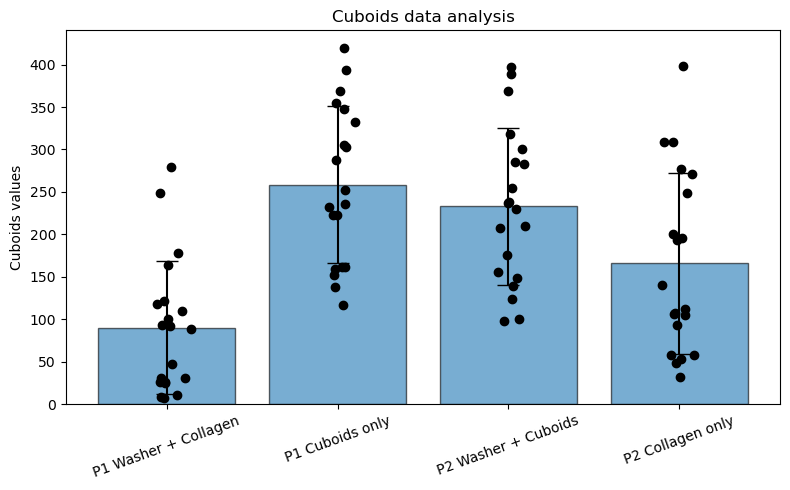

In [11]:
plate1_table = tables["Plate1"][0]
plate2_table = tables["Plate 2"][0]

# Plate 1
BC_p1 = plate1_table.loc[["B", "C"]].values.flatten().astype(float)
DE_p1 = plate1_table.loc[["D", "E"]].values.flatten().astype(float)

# Plate 2
BC_p2 = plate2_table.loc[["B", "C"]].values.flatten().astype(float)
DE_p2 = plate2_table.loc[["D", "E"]].values.flatten().astype(float)

groups = [BC_p1, DE_p1, BC_p2, DE_p2]
labels = [
    "P1 Washer + Collagen",
    "P1 Cuboids only",
    "P2 Washer + Cuboids",
    "P2 Collagen only",
]
means = [g.mean() for g in groups]
stds  = [g.std(ddof=1) for g in groups]
x = np.arange(len(groups))

plt.figure(figsize=(8, 5))

plt.bar(
    x,
    means,
    yerr=stds,
    capsize=8,
    alpha=0.6,
    edgecolor="black"
)

# Scatter points
for i, g in enumerate(groups):
    jitter = np.random.normal(0, 0.04, size=len(g))
    plt.scatter(
        np.full(len(g), x[i]) + jitter,
        g,
        color="black",
        zorder=10
    )

plt.xticks(x, labels, rotation=20)
plt.ylabel("Cuboids values")
plt.title("Cuboids data analysis")

plt.tight_layout()
plt.show()


In [ ]:
# def _sub_avg(x):
#     return x - average_values
# table = table.applymap(_sub_avg)
# table

/var/folders/34/n0768sv507xdn1r6jt0yv6600000gn/T/ipykernel_34924/2818530896.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = table.applymap(_sub_avg)


,2,3,4,5,6,7,8,9,10,11
B,26.333333,248.333333,118.333333,8.333333,178.333333,47.333333,30.333333,109.333333,26.333333,100.333333
C,30.333333,25.333333,92.333333,93.333333,121.333333,88.333333,10.333333,164.333333,279.333333,7.333333
D,138.333333,369.333333,419.333333,287.333333,161.333333,303.333333,235.333333,117.333333,305.333333,393.333333
E,159.333333,232.333333,161.333333,152.333333,354.333333,223.333333,347.333333,223.333333,252.333333,332.333333
F,-84.666667,-91.666667,-80.666667,-87.666667,-90.666667,-87.666667,-88.666667,-78.666667,-85.666667,-86.666667
G,-10.666667,3.333333,7.333333,-85.666667,-88.666667,-88.666667,-85.666667,-87.666667,-91.666667,-80.666667


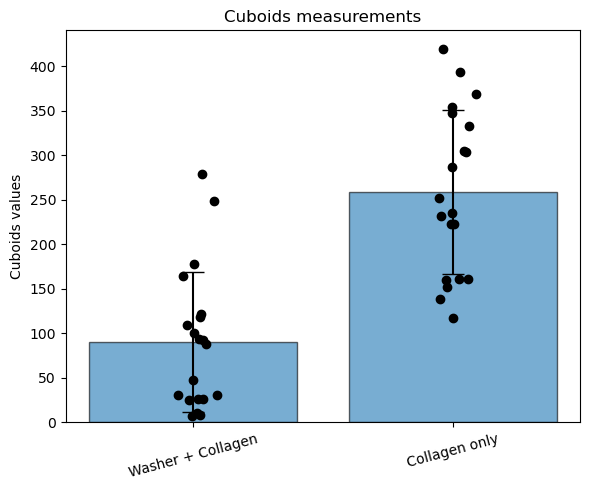

In [ ]:
BC = table.loc[["B", "C"]].values.flatten().astype(float)
DE = table.loc[["D", "E"]].values.flatten().astype(float)

groups = [BC, DE]
labels = ["Washer + Collagen", "Collagen only"]

means = [g.mean() for g in groups]
stds = [g.std(ddof=1) for g in groups]  # sample SD

x = np.arange(len(groups))

plt.figure(figsize=(6, 5))

plt.bar(x, means, yerr=stds, capsize=8, alpha=0.6,edgecolor="black")

for i, g in enumerate(groups):
    jitter = np.random.normal(0, 0.04, size=len(g))
    plt.scatter(
        np.full(len(g), x[i]) + jitter,
        g,
        color="black",
        zorder=10
    )

plt.xticks(x, labels, rotation=15)
plt.ylabel("Cuboids values")
plt.title("Cuboids data analysis")

plt.tight_layout()
plt.show()


/var/folders/34/n0768sv507xdn1r6jt0yv6600000gn/T/ipykernel_34924/280215660.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = sheet_df.astype(str).applymap(lambda x: x.strip() == anchor)
/var/folders/34/n0768sv507xdn1r6jt0yv6600000gn/T/ipykernel_34924/2789950381.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = table.applymap(_sub_avg)


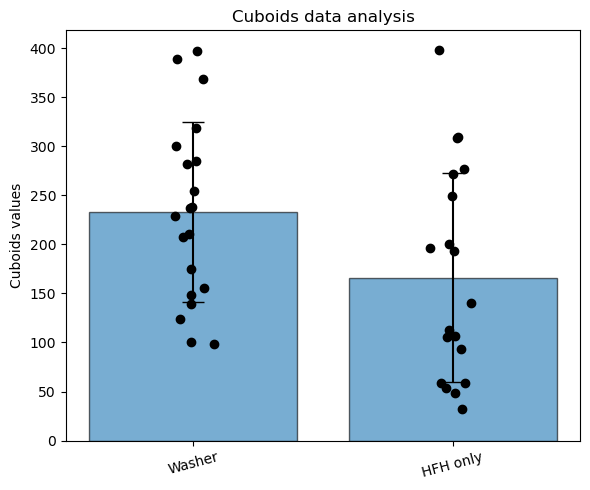

In [126]:
df = pd.read_excel("2026-01-22_MC38-12_d1_collagen_domes_ivan.xlsx",
                   sheet_name="Plate 2",
                   header=None)
table = find_table_in_sheet(df, anchor="<>")
table

def _sub_avg(x):
    return x - average_values
table = table.applymap(_sub_avg)
table

BC = table.loc[["B", "C"]].values.flatten().astype(float)
DE = table.loc[["D", "E"]].values.flatten().astype(float)

groups = [BC, DE]
labels = ["Washer", "HFH only"]

means = [g.mean() for g in groups]
stds = [g.std(ddof=1) for g in groups] 

x = np.arange(len(groups))

plt.figure(figsize=(6, 5))

plt.bar(x, means, yerr=stds, capsize=8, alpha=0.6,edgecolor="black")

for i, g in enumerate(groups):
    jitter = np.random.normal(0, 0.04, size=len(g))
    plt.scatter(
        np.full(len(g), x[i]) + jitter,
        g,
        color="black",
        zorder=10
    )

plt.xticks(x, labels, rotation=15)
plt.ylabel("Cuboids values")
plt.title("Cuboids data analysis")

plt.tight_layout()
plt.show()